<a href="https://colab.research.google.com/github/Piramu-Mahalingam/Capstone-project-1/blob/main/capstone%20project%202%20temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Imprting all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.rcParams['figure.figsize']  = (20, 8)

In [9]:
import os
os.path.exists("/content/daily-minimum-temperatures-in-me.csv")


True

In [10]:
with open("/content/daily-minimum-temperatures-in-me.csv", 'r') as f:
    for _ in range(5):
        print(f.readline())



Date,Temp,

1/1/1981,20.7,

1/2/1981,17.9,

1/3/1981,18.8,

1/4/1981,14.6,



In [11]:
df = pd.read_csv("/content/daily-minimum-temperatures-in-me.csv", delimiter=';')
print(df.columns.tolist())

['Date,Temp,']


In [ ]:
df.head()

Date,Temp,
0  1/1/1981,20.7,
1  1/2/1981,17.9,
2  1/3/1981,18.8,
3  1/4/1981,14.6,
4  1/5/1981,15.8,

In [12]:
df.shape

(3652, 1)

In [13]:
df.rename(columns={"Date":"Date", "Temp":"temp"}, inplace=True)
display(df.head())


Date,Temp,
0  1/1/1981,20.7,
1  1/2/1981,17.9,
2  1/3/1981,18.8,
3  1/4/1981,14.6,
4  1/5/1981,15.8,

In [14]:
df.dtypes

Date,Temp,    object
dtype: object

In [15]:
df.isna().sum() # now no null value is not present

Date,Temp,    0
dtype: int64

In [16]:
df = pd.read_csv("/content/daily-minimum-temperatures-in-me.csv", usecols=[0,1], header=None)
df.columns = ['Date', 'Temp']
df

Date        Temp
0                                        Date        Temp
1                                    1/1/1981        20.7
2                                    1/2/1981        17.9
3                                    1/3/1981        18.8
4                                    1/4/1981        14.6
...                                       ...         ...
3648                               12/29/1990        13.5
3649                               12/30/1990        15.7
3650                               12/31/1990          13
3651                                      NaN         NaN
3652  Daily minimum temperatures in Melbourne   Australia

[3653 rows x 2 columns]

In [17]:
import pandas as pd

# Read CSV, only first 2 columns
df = pd.read_csv("/content/daily-minimum-temperatures-in-me.csv", usecols=[0,1], header=None, engine='python')

# Keep only first two columns
df = df.iloc[:, :2]

# Assign proper column names
df.columns = ['Date', 'Temp']

# Strip whitespace and extra characters from Date column
df['Date'] = df['Date'].astype(str).str.strip()

# Convert Date to datetime (specify format if known)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')

# Convert Temp to numeric
df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')

# Drop rows with NaT or NaN
df = df.dropna().reset_index(drop=True)

# Set Date as index
df.set_index('Date', inplace=True)

# Quick check
print(df.head())



            Temp
Date            
1981-01-01  20.7
1981-02-01  17.9
1981-03-01  18.8
1981-04-01  14.6
1981-05-01  15.8


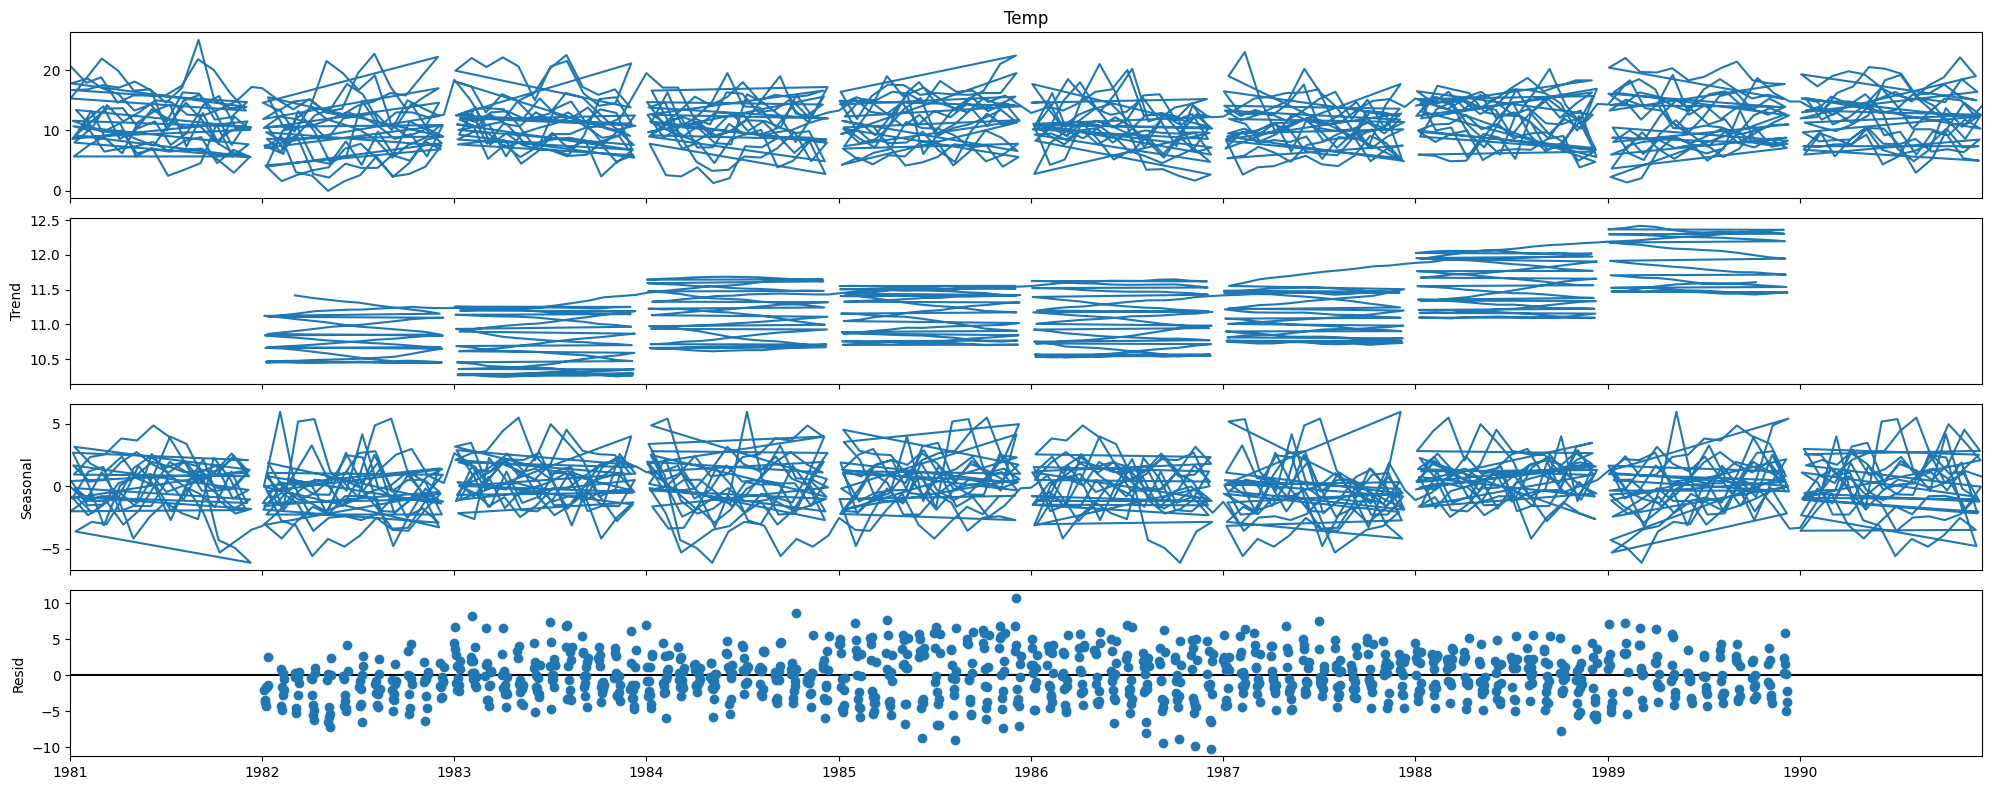

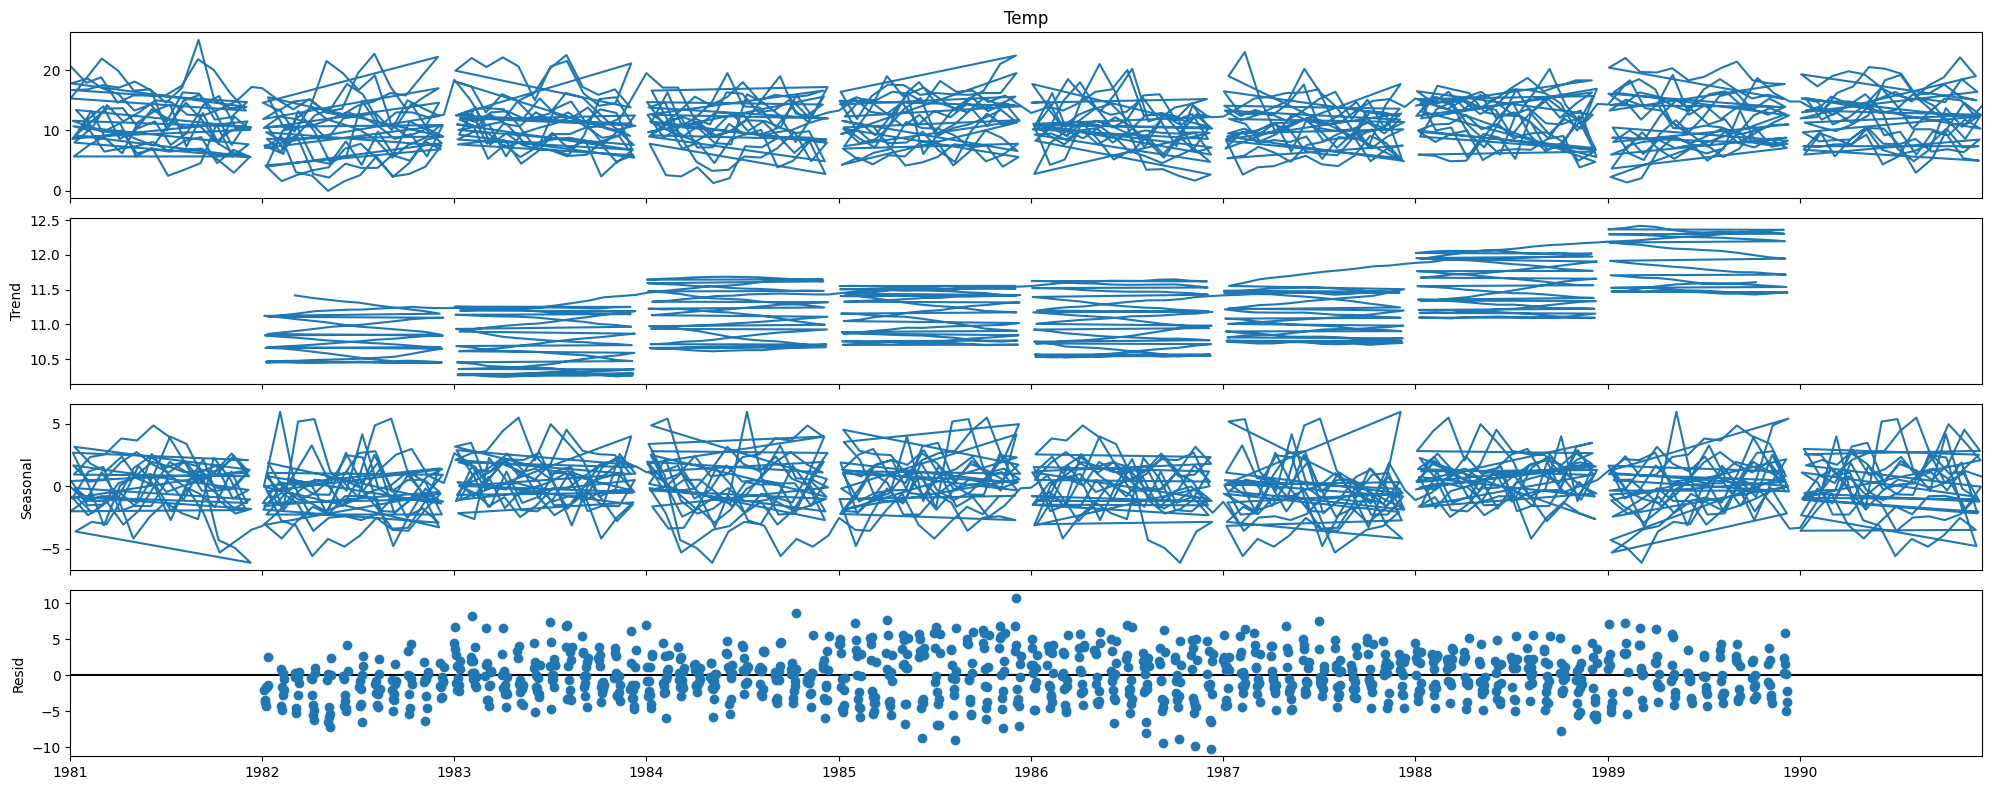

In [18]:
import statsmodels.api as sm
result = sm.tsa.seasonal_decompose(df['Temp'], period=365)
result.plot()


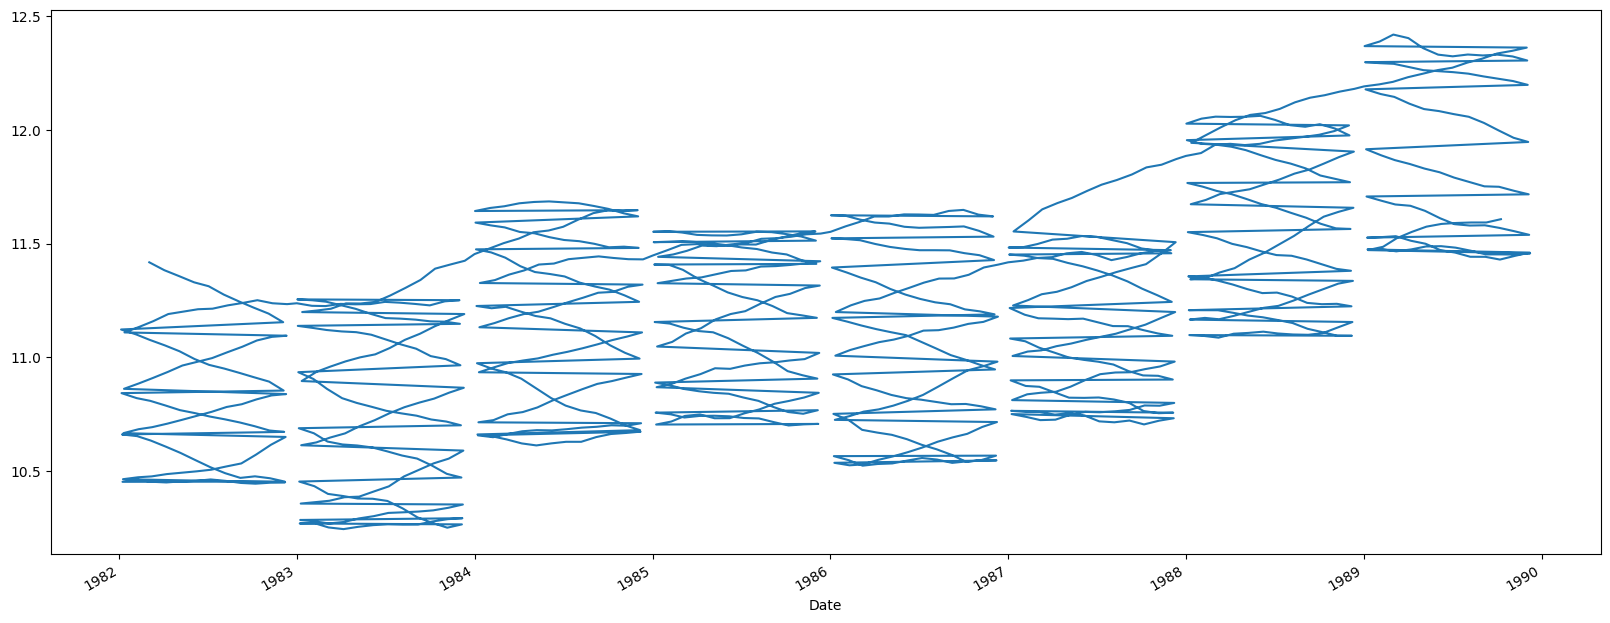

In [19]:
result.trend.plot(); # No any trend

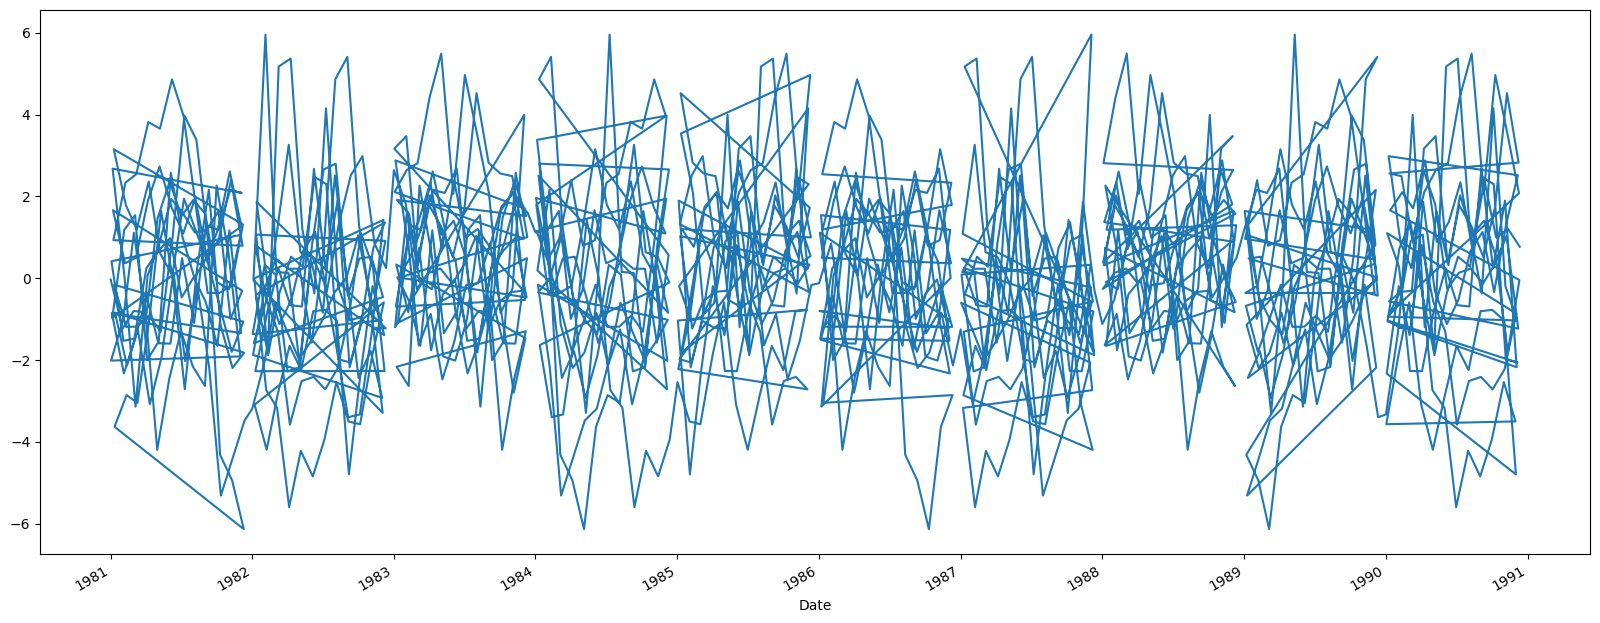

In [20]:
result.seasonal.plot(); # seasonality is there

<Axes: xlabel='Date'>

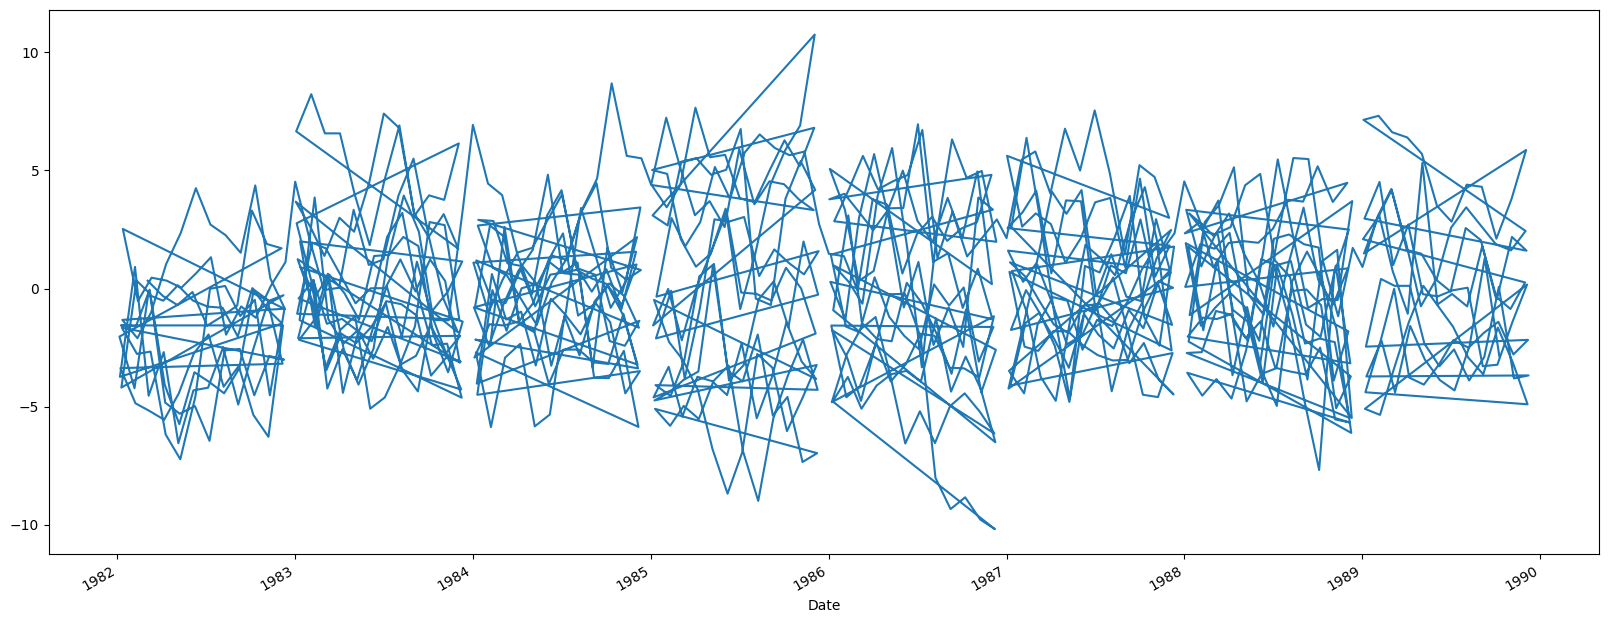

In [21]:
result.resid.plot()

In [22]:
def adf_test(data, alpha=0.05):
  p_value = adfuller(data)[1]
  if p_value < alpha:
    print("data is stationary")
  else:
    print("data is not stationary")

In [23]:
adf_test(df.Temp) # data is stationary

data is stationary


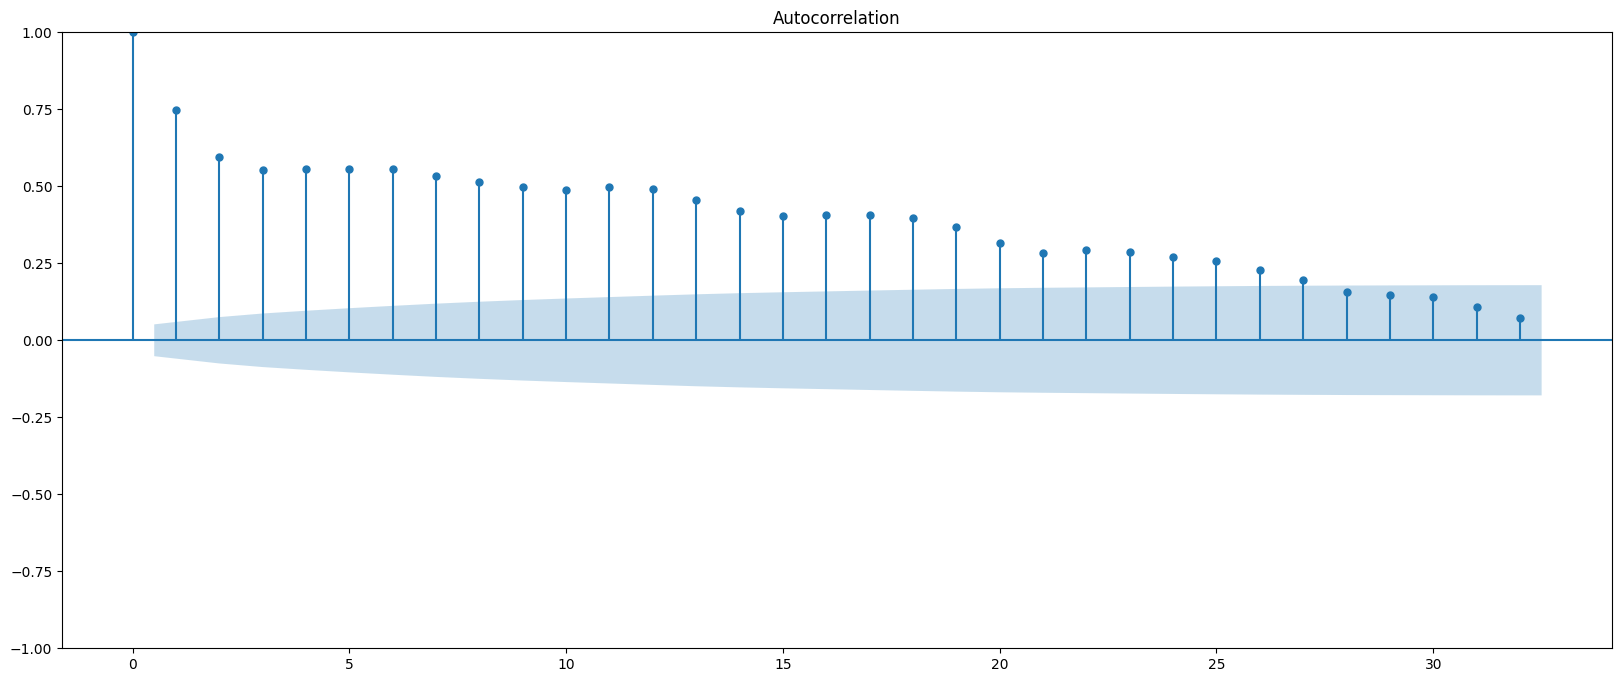

In [24]:
plot_acf(df.Temp);

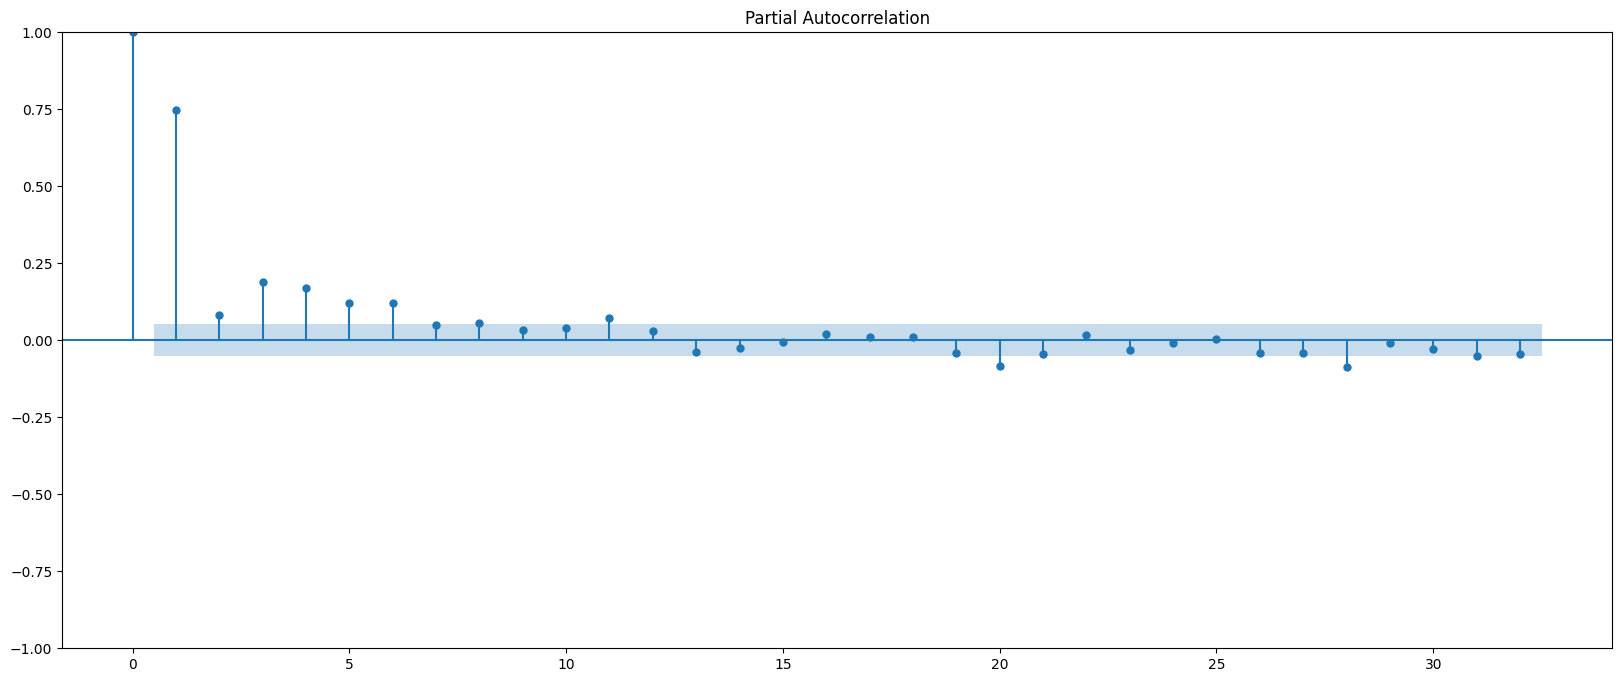

In [25]:
plot_pacf(df.Temp);

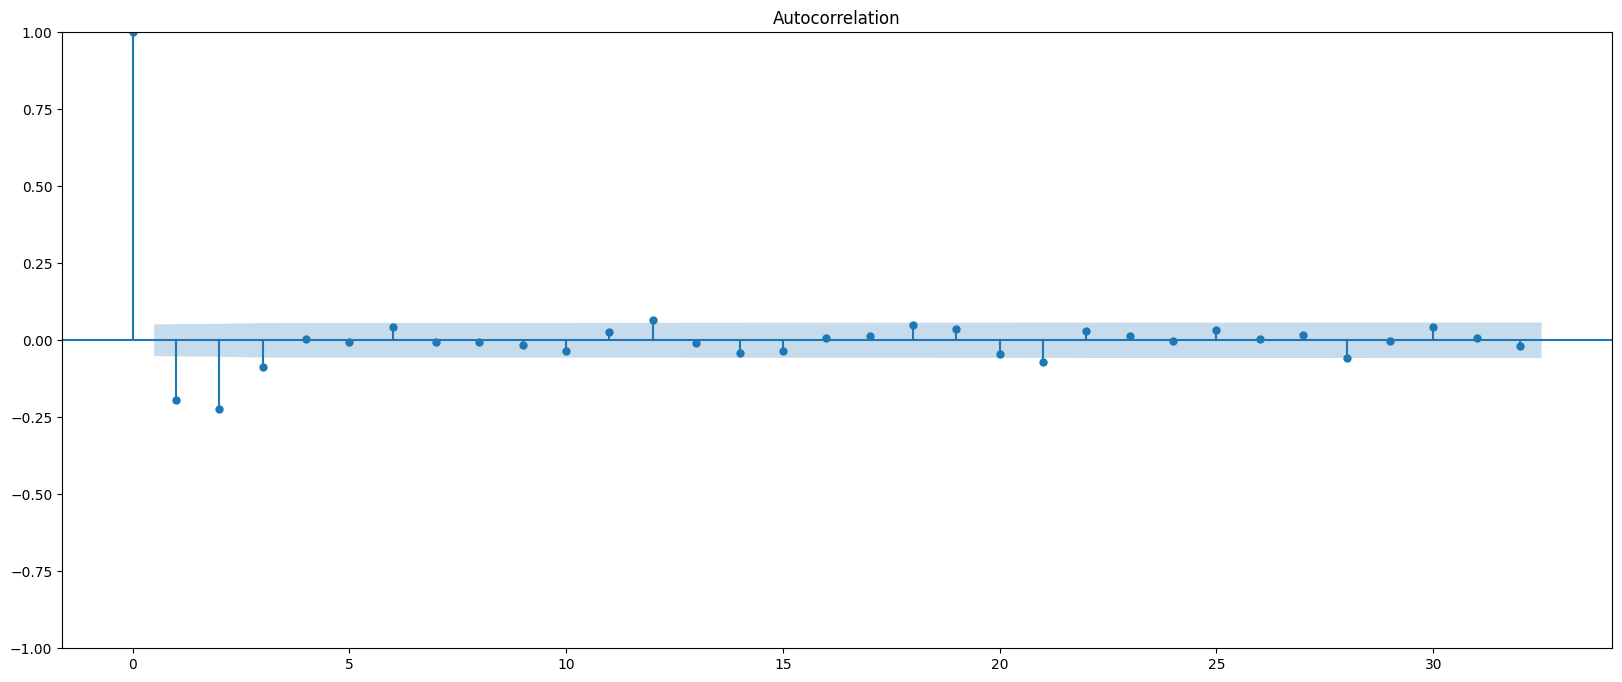

In [26]:
# acf plot doesn give proper q value - need to differentiat
plot_acf(df.Temp.diff(1).dropna());

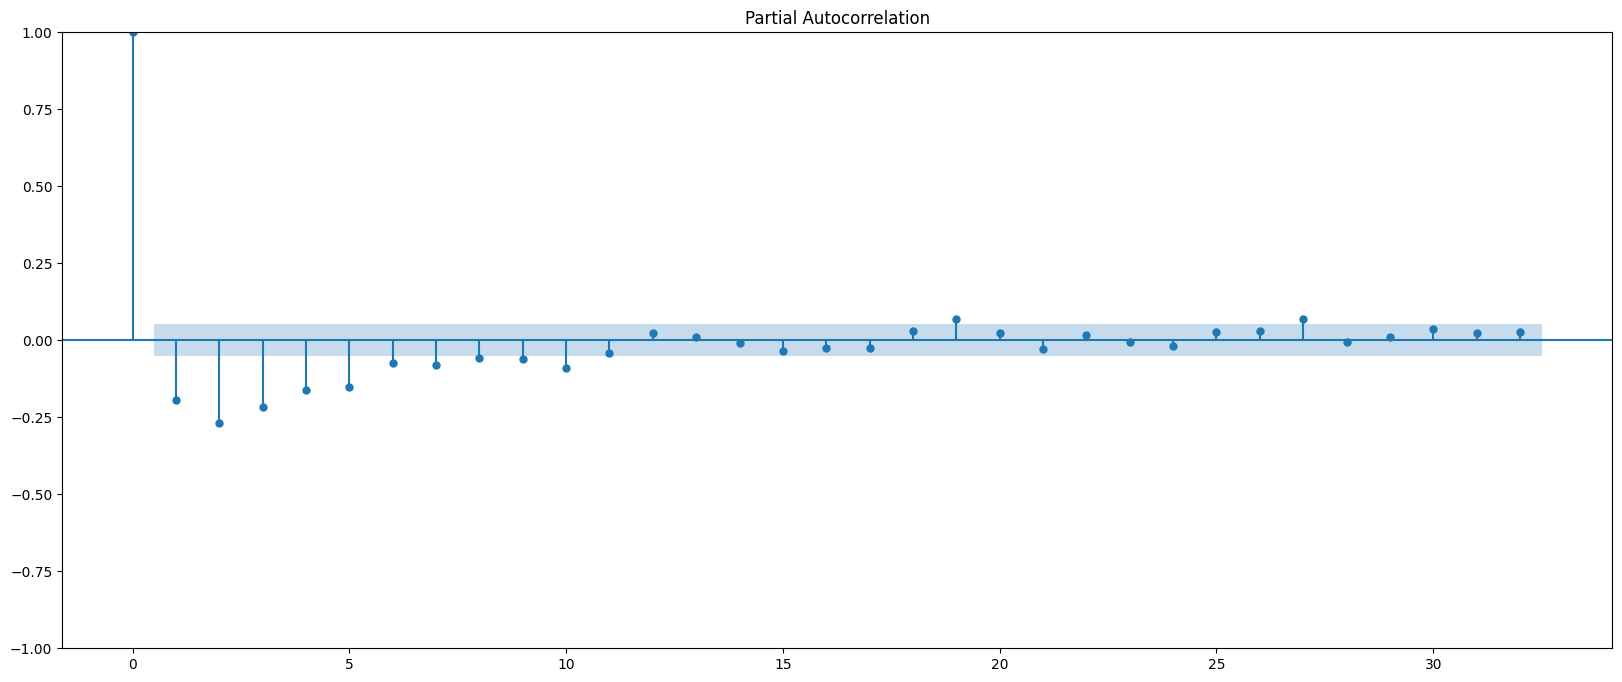

In [27]:
plot_pacf(df.Temp.diff(1).dropna());

In [28]:
# Split data in train and test set
train_index = df.index[-365]
train_data = df[df.index < train_index]
test_data = df[df.index >= train_index]

In [29]:
train_data.shape, test_data.shape

((1097, 1), (343, 1))

In [30]:
# Using exponential smoothing using seasonality
model = ExponentialSmoothing(train_data.Temp, seasonal="add", seasonal_periods=365).fit(optimized=True)
test_data["pred_es"] = model.forecast(365)
test_data

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is av

Temp  pred_es
Date                     
1988-09-01  16.5      NaN
1988-10-01  17.4      NaN
1988-11-01  18.3      NaN
1988-12-01  18.3      NaN
1988-09-02  15.1      NaN
...          ...      ...
1990-08-12  15.5      NaN
1990-09-12  14.1      NaN
1990-10-12  11.0      NaN
1990-11-12  11.1      NaN
1990-12-12  14.0      NaN

[343 rows x 2 columns]

<Axes: xlabel='Date'>

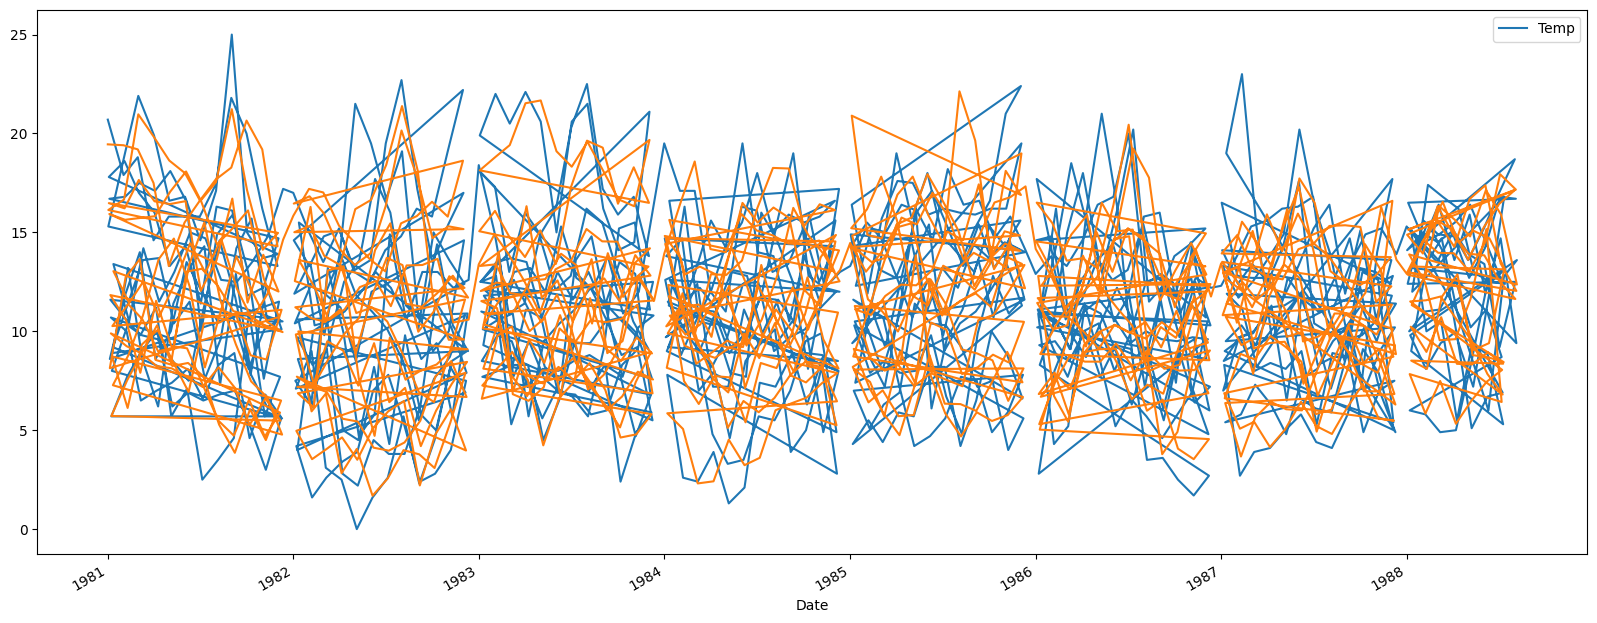

In [31]:
pred_value = model.fittedvalues
train_data.plot()
pred_value.plot()

<Axes: xlabel='Date'>

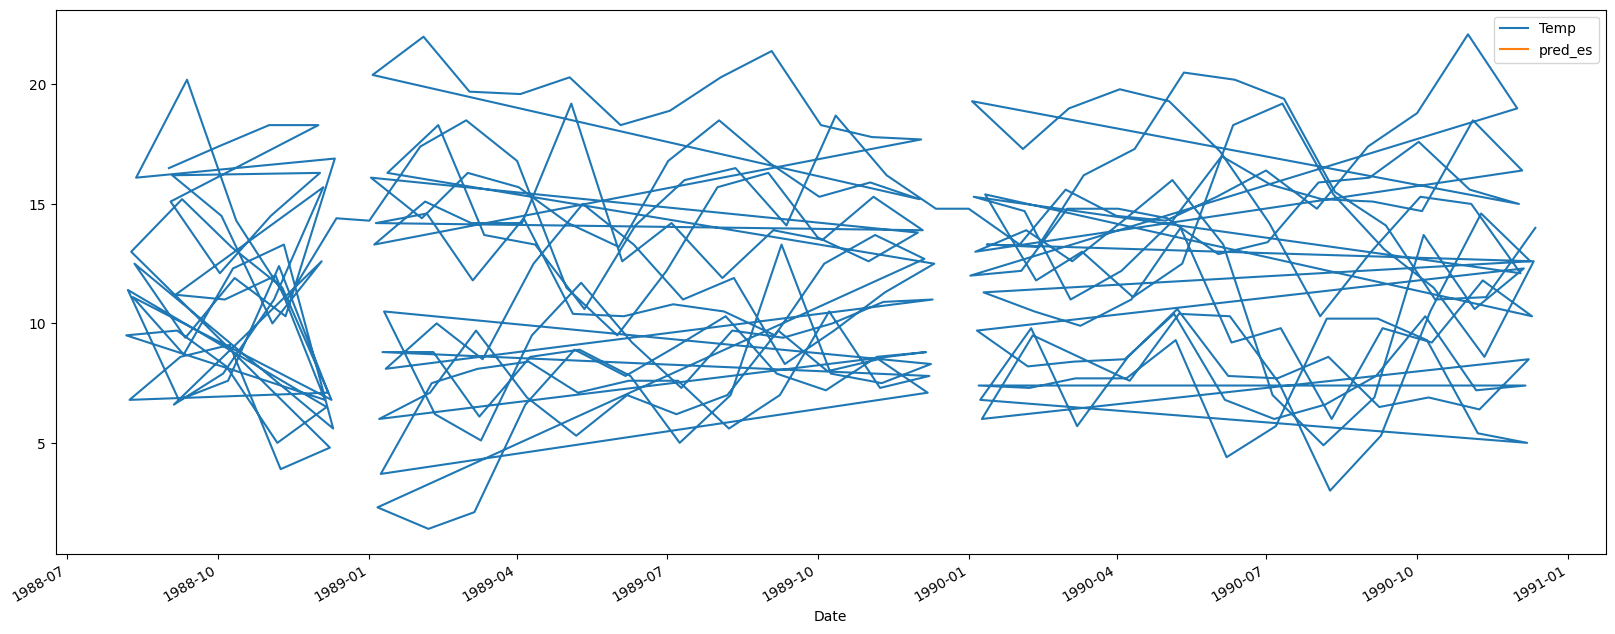

In [32]:
test_data.plot()

In [33]:
def performance(y_true, y_hat):
  print(f"MAE : {round(mae(y_true, y_hat) , 2)}")
  print(f"RMSE : {round(mse(y_true, y_hat) ** 0.05 , 2)}")
  print(f"MAPE : {round(mape(y_true, y_hat) , 2)}")

In [34]:
print(test_data.isna().sum())


Temp         0
pred_es    343
dtype: int64


In [35]:
# Option 1: Drop any rows with NaN
test_data_clean = test_data.dropna(subset=['Temp', 'pred_es'])

# Option 2: Fill NaNs with some value (not recommended for evaluation, better to drop)
# test_data_clean = test_data.fillna(method='ffill')


In [36]:
print(test_data_clean.shape)        # how many rows/columns
print(test_data_clean.head())       # preview
print(test_data_clean.isna().sum()) # check remaining NaNs



(0, 2)
Empty DataFrame
Columns: [Temp, pred_es]
Index: []
Temp       0
pred_es    0
dtype: int64


In [37]:
# Keep only rows where both target and prediction are numeric
test_data_clean = test_data[
    test_data['Temp'].notna() & test_data['pred_es'].notna()
].copy()

print(test_data_clean.shape)


(0, 2)


In [38]:
import pandas as pd

# Load file properly (no headers, keep only 2 columns)
data = pd.read_csv("/content/daily-minimum-temperatures-in-me.csv", skiprows=1, header=None)

# Keep only first two columns (date, temperature)
data = data.iloc[:, :2]
data.columns = ["Date", "Temp"]

# Convert to datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.set_index('Date', inplace=True)

# Drop any rows with NaN (if bad rows exist)
data.dropna(inplace=True)

print(data.head(), data.tail())


            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8                   Temp
Date                  
1990-12-28        13.6
1990-12-29        13.5
1990-12-30        15.7
1990-12-31          13
NaT          Australia


In [40]:
print(train_data['Temp'].dtype)
print(train_data['Temp'].head())


object
Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: object


In [44]:
#train_data['Temp'] = pd.to_numeric(train_data['Temp'], errors='coerce')
train_data.loc[:, 'Temp'] = pd.to_numeric(train_data['Temp'], errors='coerce')


In [46]:
train_data = train_data.copy()
train_data['Temp'] = train_data['Temp'].ffill()
train_data = train_data.dropna(subset=['Temp'])




In [43]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(
    train_data['Temp'],
    seasonal="add",
    seasonal_periods=365
).fit(optimized=True)

test_data["pred_es"] = model.forecast(365)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/tmp/ipython-input-2003597726.py:9: SettingWithCopyWarning: 
A value is trying t